# Calculate descriptors

MolecularGraph.jl version: 0.10.0

This tutorial includes following fundamental operations for molecular descriptors.

- Concept of descriptor function/array
- Cache mechanism
- Frequently used descriptors

In [1]:
using Pkg
Pkg.activate("..")
using MolecularGraph
using MolecularGraph.Graph
using BenchmarkTools

  Activating environment at `~/Repository/MolecularGraph.jl_notebook/Project.toml`
Path `../../MolecularGraph.jl` exists and looks like the correct package. Using existing path.
   Resolving package versions...
  No Changes to `~/Repository/MolecularGraph.jl_notebook/Project.toml`
  No Changes to `~/Repository/MolecularGraph.jl_notebook/Manifest.toml`


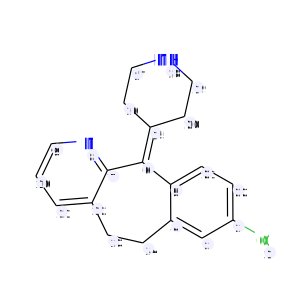

In [2]:
# Demo molecule with atom indices
mol = smilestomol("Clc4cc2c(C(/c1ncccc1CC2)=C3/CCNCC3)cc4")
canvas = SvgCanvas()
draw2d!(canvas, mol)
drawatomindex!(canvas, mol)
molsvg = tosvg(canvas, 300, 300)
display("image/svg+xml",  molsvg)

## Concept of descriptor function/array

Descriptor array is typically a vector calculated from a molecular object by a descriptor function. Most of fundamental descriptor functions are coded in `src/properties.jl`.

In [3]:
println(hydrogenconnected(mol))

[0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 2, 2, 0, 2, 2, 1, 2, 2, 1, 1]


`hydrogenconnected(mol)` returns a vector of the total number of hydrogens connected to each atom nodes. For example, atom \#13 is a secondary carbon so we can infer there is two hydrogens on it, therefore hydrogenconnected(mol)\[13\] is 2.

`hydrogenconnected` is defined as below in `src/properties.jl`

```julia
@cachefirst hydrogenconnected(mol::GraphMol
    ) = explicithconnected(mol) + implicithconnected(mol)
```

`@cachefirst` macro is to cache the results for fast calculation (described later). We can know that `hydrogenconnected` is derived from `explicithconnected` and `implicithconnected`.

`implicithconnected` is defined as below in `src/properties.jl`

```julia
@cachefirst function implicithconnected(mol::GraphMol)
    hcnt = (v, av) -> v === nothing ? 0 : max(0, v - av)
    return hcnt.(valence(mol), apparentvalence(mol))
end
```

so `implicithconnected` depends on `valence` and `apparentvalence`.

We can trace back the dependencies, and then can find these descriptors are derived from graph topologies (e.g. neighbors) and attributes (e.g. Atom.symbol and Bond.order). This descriptor function/array system can also deal with more complicated descriptors such as `isrotatable` and `isaromatic` as like a simple function that takes molecule object and returns an array without any adverse effects.

Note that manipulation of the molecular graph topology and attributes will break consistency in descriptor arrays. It is important to define molecular preprocessing workflow first, and then calculate descriptors.

## Cache mechanism

You can cache the descriptors by calling the `setcache!` method.　Its second argument is a symbol of the method name, which must be a method defined following `Graph.@cachefirst` macro.

`Graph.@cachefirst` macro first checks if the `GraphMol` given as a first argument of the method caches the result, and returns the cache if it exists, or returns the result of executing the method if it does not.

In [4]:
mol2 = clone(mol)
setcache!(mol2, :valence);
mol2.cache

Dict{Symbol, Any} with 1 entry:
  :valence => Union{Nothing, Int64}[1, 4, 4, 4, 4, 4, 4, 3, 4, 4  …  4, 4, 4, 4…

In [5]:
@benchmark valence(mol)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  10.543 μs …  2.595 ms  ┊ GC (min … max): 0.00% … 99.48%
 Time  (median):     11.021 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   11.493 μs ± 25.893 μs  ┊ GC (mean ± σ):  2.25% ±  0.99%

  █                                                            
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▁  ▁
  35.4 μs         Histogram: frequency by time        10.9 μs <

 Memory estimate: 7.27 KiB, allocs estimate: 106.

In [6]:
@benchmark valence(mol2)

BenchmarkTools.Trial: 10000 samples with 993 evaluations.
 Range (min … max):  35.309 ns … 303.739 ns  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     35.777 ns               ┊ GC (median):    0.00%
 Time  (mean ± σ):   36.708 ns ±   6.441 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █                                                             
  █▁▁▁▁▁ ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▁▁ ▁
  39.7 ns         Histogram: frequency by time         35.7 ns <

 Memory estimate: 0 bytes, allocs estimate: 0.

### Tips

- Some descriptor function allows keyword arguments (e.g. `coordgen(mol; forcecoordgen=true)`). If keyword arguments are given explicitly, cache will not be used.
- If the molecule object is modified (e.g. by preprocessing methods), you may want to recalculate and cache the result by calling the function with `setcache!` again.
- `clearcache!(mol)` empties the cache dict.
- `precalculate!(mol)` is a convenient method to cache several cost-effective descriptors together. It is recommended to run this method after loading and preprocessing the molecule.

In [7]:
clearcache!(mol2)
mol2.cache

Dict{Symbol, Any}()

In [8]:
precalculate!(mol2)
mol2.cache

Dict{Symbol, Any} with 7 entries:
  :minimumcyclebasis => [[5, 6, 12, 13, 14, 15, 4], [23, 24, 25, 2, 3, 4], [18,…
  :lonepair          => Union{Nothing, Int64}[3, 0, 0, 0, 0, 0, 0, 1, 0, 0  …  …
  :coordgen          => ([202.23 -96.8; 158.81 -72.0; … ; 115.16 2.79; 158.57 -…
  :sssr              => [[4, 14, 13, 12, 7, 6, 5], [4, 3, 2, 22, 21, 5], [15, 2…
  :valence           => Union{Nothing, Int64}[1, 4, 4, 4, 4, 4, 4, 3, 4, 4  …  …
  :apparentvalence   => [1, 4, 3, 4, 4, 4, 4, 3, 3, 3  …  2, 2, 4, 2, 2, 2, 2, …
  :isaromaticring    => Bool[0, 1, 0, 1]

## Convention of descriptor functions

For reproducibility, there is some important conventions for descriptor functions.

- All descriptor functions take a GraphMol or SubgraphView as the only argument (optional keyword arguments are acceptable but caching will not work).
- All descriptor functions never change the molecule object given as an argument.
- All descriptor functions only refer the molecular graph and attributes, other descriptor arrays and global constants. Other external mutable objects are never refered from inside the function.
- Return values of all descriptor functions must be in Julia built-in collection type (for serialization to JSON)

## Frequently used descriptors


`sssr(mol)`: smallest set of smallest rings (List of rings by node set).

In [9]:
sssr(mol)

4-element Vector{Vector{Int64}}:
 [4, 14, 13, 12, 7, 6, 5]
 [4, 3, 2, 22, 21, 5]
 [15, 20, 19, 18, 17, 16]
 [11, 10, 9, 8, 7, 12]

`isringatom(mol)`: whether the atom is a member of ring

In [10]:
print(isringatom(mol))

Bool[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

`isringbond(mol)`: whether the bond is a member of ring

In [11]:
print(isringbond(mol))

Bool[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]

`fusedrings(mol)`: list of fused ring systems by node set

In [12]:
fusedrings(mol)

2-element Vector{Set{Int64}}:
 Set([5, 20, 7, 12, 8, 1, 4, 6, 13, 11, 21, 2, 9, 10, 3])
 Set([16, 15, 18, 14, 17, 19])

`Graph.connectedcomponents(mol)`: list of connected components (molecules) by node set.

`ishacceptor(mol)`: whether the atom is a hydrogen acceptor or not (N, O or F with free lone pairs)

In [13]:
print(ishacceptor(mol))

Bool[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]

`ishdonor(mol)`: whether the atom is a hydrogen donor or not (N or O with hydrogens)

In [14]:
print(ishdonor(mol))

Bool[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]

`isrotatable(mol)`: whether the bond is rotatable or not

In [15]:
print(isrotatable(mol))

Bool[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

`hybridization(mol)`: hybridization of molecular orbitals

In [16]:
print(hybridization(mol))

[:sp3, :sp2, :sp2, :sp2, :sp2, :sp2, :sp2, :sp2, :sp2, :sp2, :sp2, :sp2, :sp3, :sp3, :sp2, :sp3, :sp3, :sp3, :sp3, :sp3, :sp2, :sp2]

`isaromatic(mol)`: whether the atom is in aromatic ring

In [17]:
print(isaromatic(mol))

Bool[0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]

`isaromaticbond(mol)`: whether the bond is in aromatic ring

In [18]:
print(isaromaticbond(mol))

Bool[0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1]